Dados carregados: 2020-06-01 00:00:00 → 2025-05-31 00:00:00 | pontos = 1826


01:27:37 - cmdstanpy - INFO - Chain [1] start processing
01:27:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet | Horizonte=1 dias → MAPE: 13.85%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM | Horizonte=1 dias → MAPE: 3.91%


01:30:07 - cmdstanpy - INFO - Chain [1] start processing
01:30:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet | Horizonte=3 dias → MAPE: 13.85%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM | Horizonte=3 dias → MAPE: 2.60%


01:32:04 - cmdstanpy - INFO - Chain [1] start processing
01:32:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet | Horizonte=7 dias → MAPE: 13.85%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM | Horizonte=7 dias → MAPE: 4.16%


01:33:27 - cmdstanpy - INFO - Chain [1] start processing
01:33:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet | Horizonte=14 dias → MAPE: 13.85%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
01:34:15 - cmdstanpy - INFO - Chain [1] start processing


LSTM | Horizonte=14 dias → MAPE: 3.90%


01:34:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet | Horizonte=30 dias → MAPE: 13.85%


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM | Horizonte=30 dias → MAPE: 9.52%
Resultados salvos em: results/summary_26-09.csv


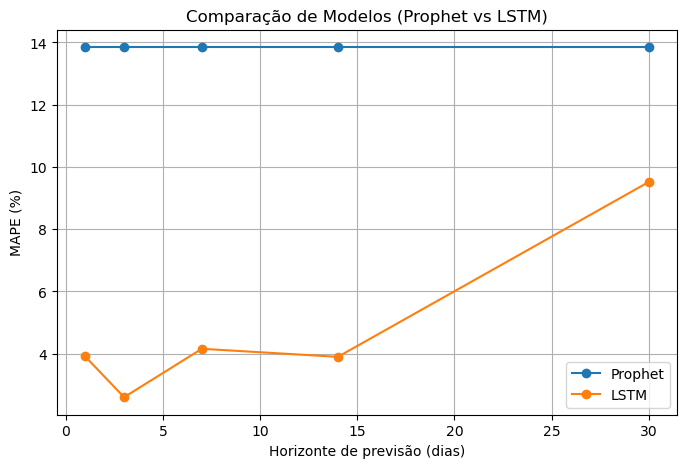

,Modelo,Horizonte,MAPE
0,Prophet,1,13.846952
1,LSTM,1,3.911335
2,Prophet,3,13.846952
3,LSTM,3,2.602157
4,Prophet,7,13.846952
5,LSTM,7,4.158121
6,Prophet,14,13.846952
7,LSTM,14,3.899309
8,Prophet,30,13.846952
9,LSTM,30,9.519704


In [1]:
# [1] Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import datetime
import os

# -------------------------------
# [2] Carregar CSV
# -------------------------------
def load_csv(path='data/btc_limpo.csv'):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df = df.dropna(subset=['Close']).reset_index(drop=True)
    return df

df = load_csv()
print('Dados carregados:', df['Date'].min(), '→', df['Date'].max(), '| pontos =', len(df))

# -------------------------------
# [3] Funções utilitárias
# -------------------------------
def prepare_multistep_data(series, lookback=30, horizon=7):
    X, y = [], []
    for i in range(len(series) - lookback - horizon):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback:i+lookback+horizon])
    return np.array(X), np.array(y)

def run_lstm_multistep(train, test, lookback=30, horizon=7, epochs=30, batch_size=32):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(train.reshape(-1,1))

    X_train, y_train = prepare_multistep_data(scaled.flatten(), lookback, horizon)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50),
        Dense(horizon)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    inputs = np.concatenate([train[-lookback:], test])
    inputs_scaled = scaler.transform(inputs.reshape(-1,1))

    preds = []
    for i in range(0, len(test), horizon):
        last_input = inputs_scaled[i:i+lookback].reshape(1, lookback, 1)
        pred_scaled = model.predict(last_input, verbose=0)
        pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
        preds.extend(pred)

    return np.array(preds[:len(test)])

def run_prophet_multistep(train_df, test_df, horizon=7):
    prophet_df = train_df[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
    m = Prophet(daily_seasonality=True, yearly_seasonality=True)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=len(test_df), freq='D')
    forecast = m.predict(future)
    return forecast['yhat'].values[-len(test_df):]

def evaluate(y_true, y_pred, model_name, horizon):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"{model_name} | Horizonte={horizon} dias → MAPE: {mape:.2f}%")
    return mape

# -------------------------------
# [4] Rodar todos os experimentos
# -------------------------------
results = []
train_size = len(df) - 60
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]
train, test = train_df['Close'].values, test_df['Close'].values

horizons = [1, 3, 7, 14, 30]

for horizon in horizons:
    # Prophet
    prophet_preds = run_prophet_multistep(train_df, test_df, horizon)
    mape_p = evaluate(test[:len(prophet_preds)], prophet_preds, "Prophet", horizon)
    results.append(['Prophet', horizon, mape_p])

    # LSTM
    lstm_preds = run_lstm_multistep(train, test, lookback=30, horizon=horizon, epochs=30)
    mape_l = evaluate(test[:len(lstm_preds)], lstm_preds, "LSTM", horizon)
    results.append(['LSTM', horizon, mape_l])

# -------------------------------
# [5] Organizar resultados
# -------------------------------
results_df = pd.DataFrame(results, columns=['Modelo','Horizonte','MAPE'])

today = datetime.date.today().strftime('%d-%m')
os.makedirs('results', exist_ok=True)
results_path = f'results/summary_{today}.csv'
results_df.to_csv(results_path, index=False)
print("Resultados salvos em:", results_path)

# -------------------------------
# [6] Gráfico comparativo
# -------------------------------
plt.figure(figsize=(8,5))
for model in results_df['Modelo'].unique():
    subset = results_df[results_df['Modelo']==model]
    plt.plot(subset['Horizonte'], subset['MAPE'], marker='o', label=model)

plt.xlabel('Horizonte de previsão (dias)')
plt.ylabel('MAPE (%)')
plt.title('Comparação de Modelos (Prophet vs LSTM)')
plt.legend()
plt.grid(True)
plt.savefig(f'results/comparacao_{today}.png', dpi=150)
plt.show()

# -------------------------------
# [7] Tabela final
# -------------------------------
results_df
